           Date  Heat Flux Density (kW/m²)  Fractional Area
0    2019-07-06                 290.943743         0.741085
1    2019-07-07                 278.033048         0.740710
2    2019-07-08                 363.147219         0.551261
3    2019-07-09                 258.638493         0.684327
4    2019-07-10                 257.008937         0.682457
...         ...                        ...              ...
1209 2023-09-12                 332.356029         0.731996
1210 2023-09-13                 402.929219         0.775075
1211 2023-09-14                 349.966101         0.724894
1212 2023-09-15                 321.318504         0.673967
1213 2023-09-16                 331.449023         0.714378

[1214 rows x 3 columns]
Data saved to heat_flux_density_data.csv


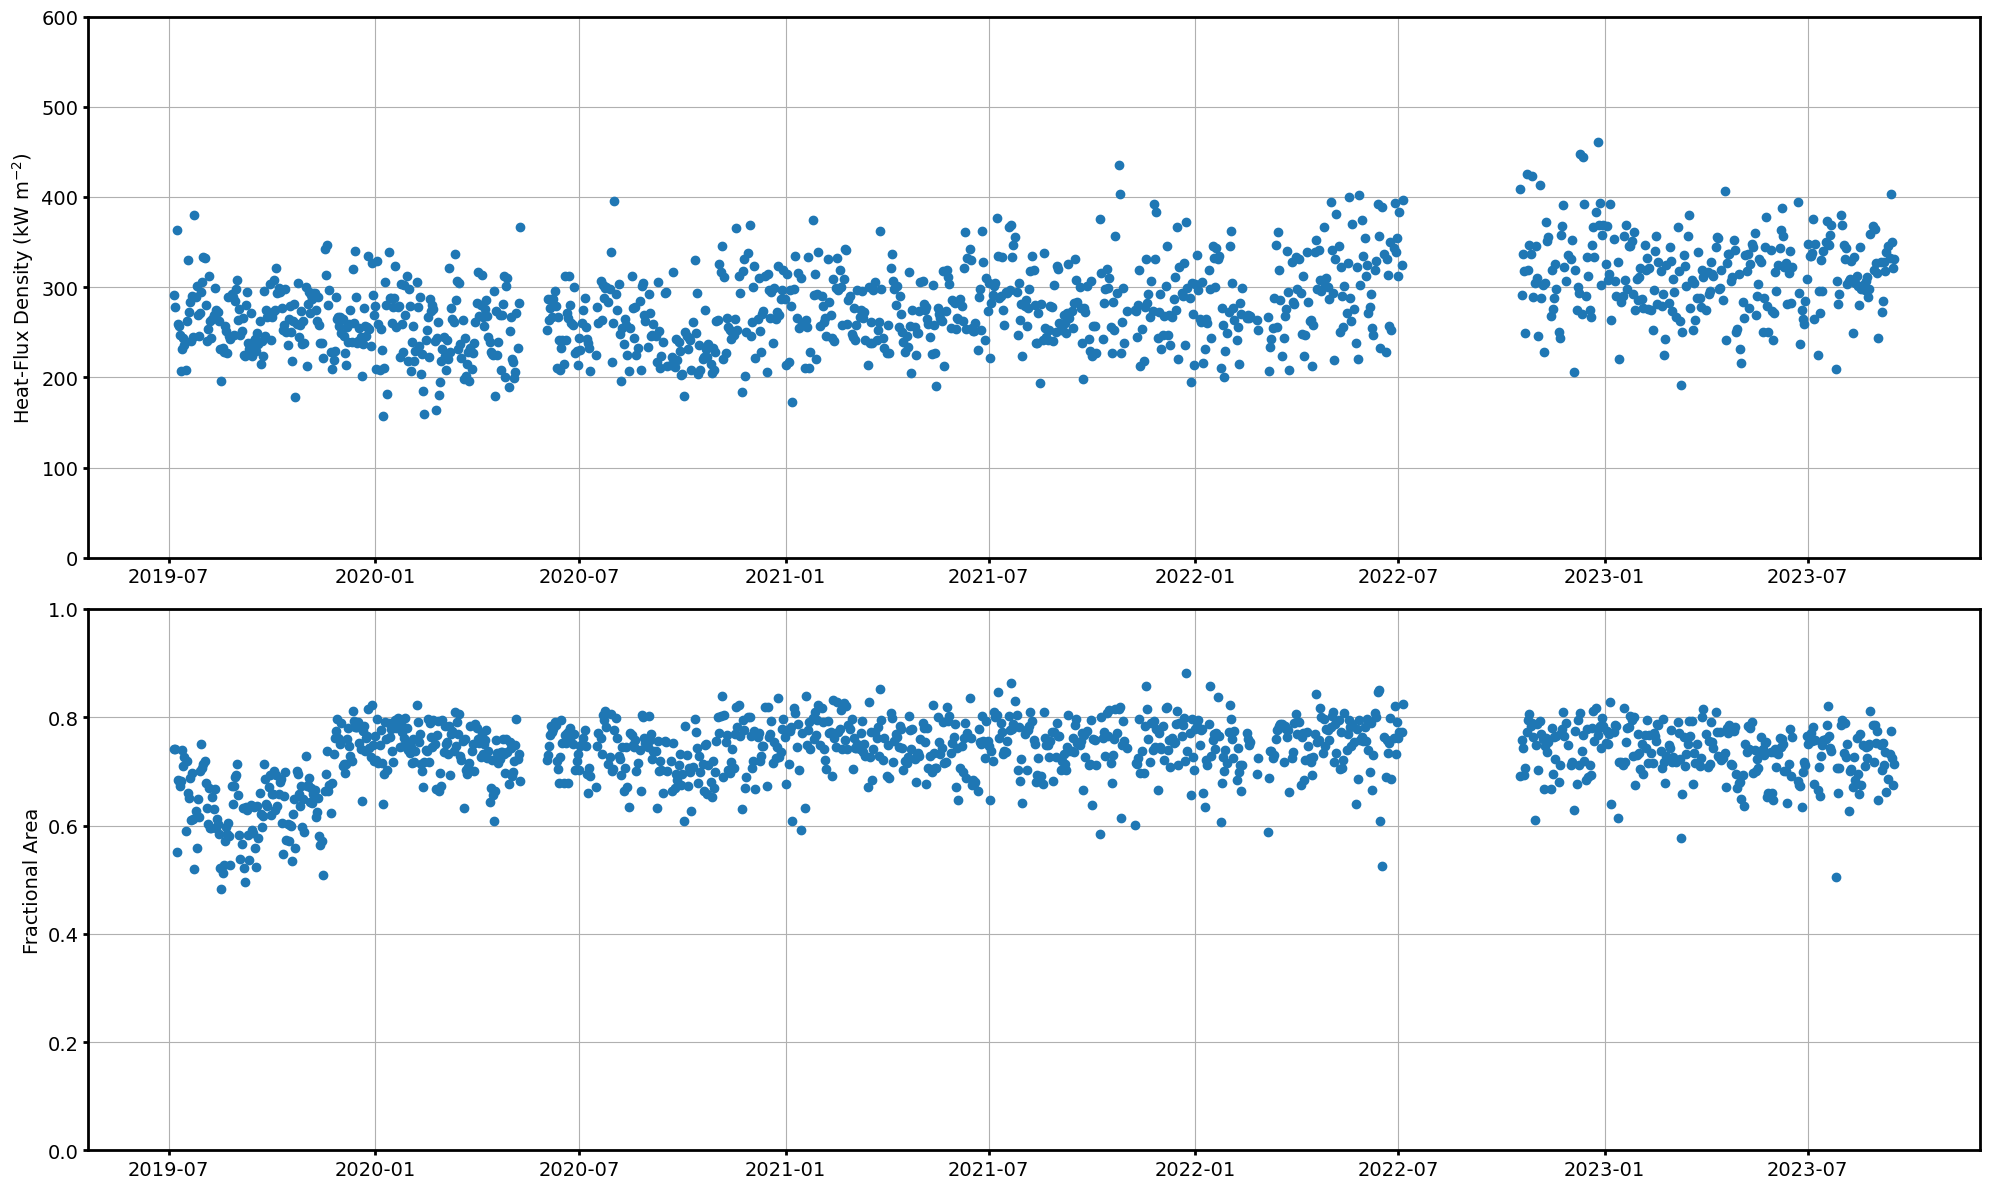

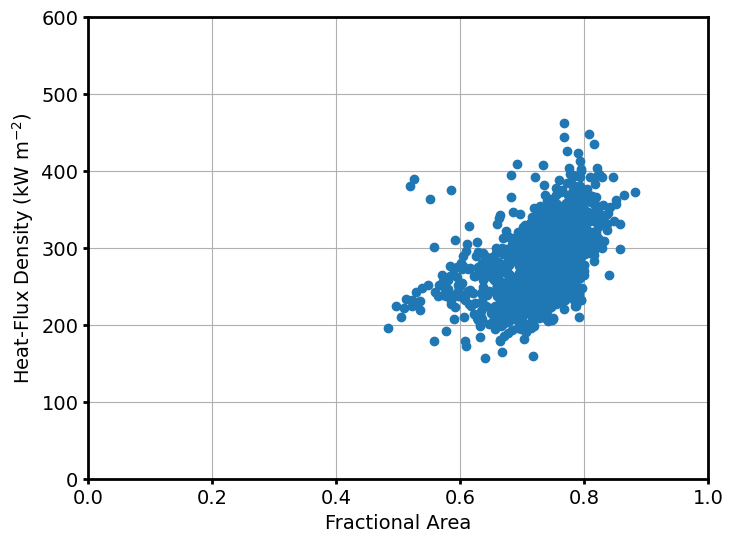

In [1]:
# -----------------------------------------------------------
# Imports, setup tasks, and data load
# -----------------------------------------------------------

import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio   # For loading .mat files
from datetime import datetime
import matplotlib.dates as mdates
import pandas as pd

# Define the path to the directory containing the .mat files.
path = 'heat_flux_results/'

# Use glob to find all .mat files matching the source data filename pattern (e.g., "heat_flux_density_sector_1*.mat").
file_pattern = os.path.join(path, 'heat_flux_density_sector_1*.mat')
mat_files = sorted(glob.glob(file_pattern))
no_files = len(mat_files)

# Initialize lists to store computed values and date information.
q_av_list = []       # List for average heat flux density (W/m^2)
A_fract_list = []    # List for fractional active area
year_list = []       # List for years extracted from filenames
month_list = []      # List for months extracted from filenames
day_list = []        # List for days extracted from filenames

# Loop over each .mat file.
for i, filename in enumerate(mat_files):
    # Load the .mat file using SciPy. This returns a dictionary containing variables.
    data = sio.loadmat(filename)
    
    # Extract variables 'x', 'y', and 'q_trim' from the loaded data.
    x = data['x']
    y = data['y']
    q_trim = data['q_trim']  # This should be a 2D NumPy array representing heat flux density.
    
    # For the first file, compute grid spacing and the polar coordinate arrays (r and phi)
    # that are assumed to be the same for all files.
    if i == 0:
        # Compute grid spacing in x and y directions.
        # MATLAB uses 1-indexing (x(1,2)-x(1,1)); here we use 0-indexing.
        delx = x[0, 1] - x[0, 0]
        dely = y[1, 0] - y[0, 0]
        
        # Compute the radial distance from the origin for each grid point.
        r = np.sqrt(x**2 + y**2)
        
        # Compute the angle in degrees.
        # Note: MATLAB uses "atan2(x,y)" here, although the typical order is (y,x).
        # To mimic the MATLAB behavior exactly, call np.arctan2(x, y) (even though
        # NumPy’s arctan2 convention is arctan2(y, x)).
        phi = 180 / np.pi * np.arctan2(x, y)
    
    # -----------------------------------------------------------
    # Trim regions corresponding to the "Mushroom" and "Inferno" shadows.
    # -----------------------------------------------------------
    
    # ----- Mushroom Shadow Trimming -----
    # Compute the minimum radial distance using the Euclidean norm of [-3.75, 7.25].
    rmin_mush = np.linalg.norm(np.array([-3.75, 7.25]))
    # Compute the minimum and maximum angles (in degrees) defining the Mushroom region.
    phi_min_mush = 180 / np.pi * np.arctan2(-13.75, 11.75)
    phi_max_mush = 180 / np.pi * np.arctan2(-8.75, 18.25)
    # Create a boolean mask for grid points that satisfy the Mushroom shadow criteria.
    mushroom_mask = (phi > phi_min_mush) & (phi < phi_max_mush) & (r > rmin_mush)
    # Set the q_trim values in the Mushroom region to NaN to exclude these points.
    q_trim[mushroom_mask] = np.nan

    # ----- Inferno Shadow Trimming -----
    # Define the minimum radial distance for the Inferno region.
    rmin_inferno = 11.25
    # Compute the angular bounds (in degrees) for the Inferno region.
    phi_min_inferno = 180 / np.pi * np.arctan2(-19.25, -4.75)
    phi_max_inferno = 180 / np.pi * np.arctan2(-18.75, 4.25)
    # Create a mask for the Inferno region.
    inferno_mask = (phi > phi_min_inferno) & (phi < phi_max_inferno) & (r > rmin_inferno)
    # Exclude these points by setting them to NaN.
    q_trim[inferno_mask] = np.nan

    # -----------------------------------------------------------
    # Calculate total power, active area, and effective area.
    # -----------------------------------------------------------
    
    # Make a copy of q_trim for further calculations.
    q_trimm = q_trim.copy()
    # Identify where q_trimm is NaN.
    nan_mask = np.isnan(q_trimm)
    # Replace NaNs with 0 for the power calculation.
    q_trimm[nan_mask] = 0
    # Compute the total power (W) by summing q_trimm and multiplying by the area element.
    P = delx * dely * np.sum(q_trimm)
    
    # ----- Total Active Area Calculation -----
    # To compute the total active area, we want to count grid points where the heat flux is defined.
    # Create a temporary copy and set the previously NaN points to -1.
    # The sign function will yield -1 for these, and 0.5*(sign+1) will then give 0.
    q_temp = q_trimm.copy()
    q_temp[nan_mask] = -1
    # The total area A is the sum over grid points (each contributing an area of delx*dely)
    # where the heat flux is defined (i.e., where q_temp is positive).
    A = delx * dely * np.sum(0.5 * (np.sign(q_temp) + 1))
    
    # ----- Effective Area Calculation -----
    # The effective area is defined using the formula:
    #   A_eff = (delx*dely)*(sum(q_trimm)^2) / sum(q_trimm^2)
    # This weights the area by the distribution of heat flux.
    A_eff = delx * dely * (np.sum(q_trimm) ** 2) / np.sum(q_trimm ** 2)
    
    # -----------------------------------------------------------
    # Compute the average heat flux density and fractional active area.
    # -----------------------------------------------------------
    
    # Average heat flux density (W/m^2) is the total power divided by the total active area.
    q_av = P / A
    # Fractional Active Area is defined as the ratio of the effective area to the total active area.
    A_fract = A_eff / A
    
    # Append the computed values to their respective lists.
    q_av_list.append(q_av)
    A_fract_list.append(A_fract)
    
    # -----------------------------------------------------------
    # Extract date information from the filename.
    # -----------------------------------------------------------
    # In the MATLAB code, the year is taken from characters 34-37, month from 38-39,
    # and day from 40-41. Adjusting for Python's 0-indexing:
    #   Year: indices 33 to 37, Month: indices 37 to 39, Day: indices 39 to 41.
    base_filename = os.path.basename(filename)
    year_str = base_filename[33:37]
    month_str = base_filename[37:39]
    day_str = base_filename[39:41]
    # Convert the extracted strings to integers.
    year_list.append(int(year_str))
    month_list.append(int(month_str))
    day_list.append(int(day_str))

# -----------------------------------------------------------
# Create datetime objects for plotting based on the extracted dates.
# -----------------------------------------------------------
t_plot = [datetime(y, m, d) for y, m, d in zip(year_list, month_list, day_list)]

# -----------------------------------------------------------
# Plot Results
# -----------------------------------------------------------

# Create the first figure with two subplots.
plt.figure(figsize=(20, 12))

# ----- Subplot 1: Average Heat Flux Density vs. Time -----
plt.subplot(2, 1, 1)
# Plot the average heat flux density (converted to kW/m^2 by dividing by 1000).
plt.plot(t_plot, np.array(q_av_list) / 1000, 'o', linewidth=1)
plt.grid(True)
plt.ylabel('Heat-Flux Density (kW m$^{-2}$)', fontsize=14)
plt.ylim(0, 600)
# Enhance axis appearance by increasing line widths and tick sizes.
ax1 = plt.gca()
for spine in ax1.spines.values():
    spine.set_linewidth(2)
ax1.tick_params(width=2, labelsize=14)

# ----- Subplot 2: Fractional Active Area vs. Time -----
plt.subplot(2, 1, 2)
plt.plot(t_plot, A_fract_list, 'o', linewidth=1)
plt.grid(True)
plt.ylabel('Fractional Area', fontsize=14)
plt.ylim(0, 1)
ax2 = plt.gca()
for spine in ax2.spines.values():
    spine.set_linewidth(2)
ax2.tick_params(width=2, labelsize=14)
plt.tight_layout()

# Create the second figure: Average Heat Flux Density vs. Fractional Active Area.
plt.figure(figsize=(8, 6))
plt.plot(A_fract_list, np.array(q_av_list) / 1000, 'o', linewidth=1)
plt.xlim(0, 1)
plt.ylim(0, 600)
plt.ylabel('Heat-Flux Density (kW m$^{-2}$)', fontsize=14)
plt.xlabel('Fractional Area', fontsize=14)
plt.grid(True)
ax3 = plt.gca()
for spine in ax3.spines.values():
    spine.set_linewidth(2)
ax3.tick_params(width=2, labelsize=14)

# Create a Pandas dataframe
df = pd.DataFrame({
    "Date": t_plot,  # Already in datetime format
    "Heat Flux Density (kW/m²)": np.array(q_av_list) / 1000,  # Convert from W/m² to kW/m²
    "Fractional Area": A_fract_list
})

# Print the dataframe
print(df)

# Save the dataframe to a CSV file
csv_filename = "heat_flux_density_data.csv"
df.to_csv(csv_filename, index=False)  # Save without the index column
print(f"Data saved to {csv_filename}")

In [2]:
# # Code added to share data with Karen's students
# # Save t_plot (list of datetime objects) as CSV
# pd.Series(t_plot).to_csv("t_plot.csv", index=False)

# # Save q_av_list and A_fract_list as .npy files (easy, fast for numeric arrays)
# np.save("q_av_list.npy", np.array(q_av_list))
# np.save("A_fract_list.npy", np.array(A_fract_list))

# print("Files saved: t_plot.csv, q_av_list.npy, A_fract_list.npy")

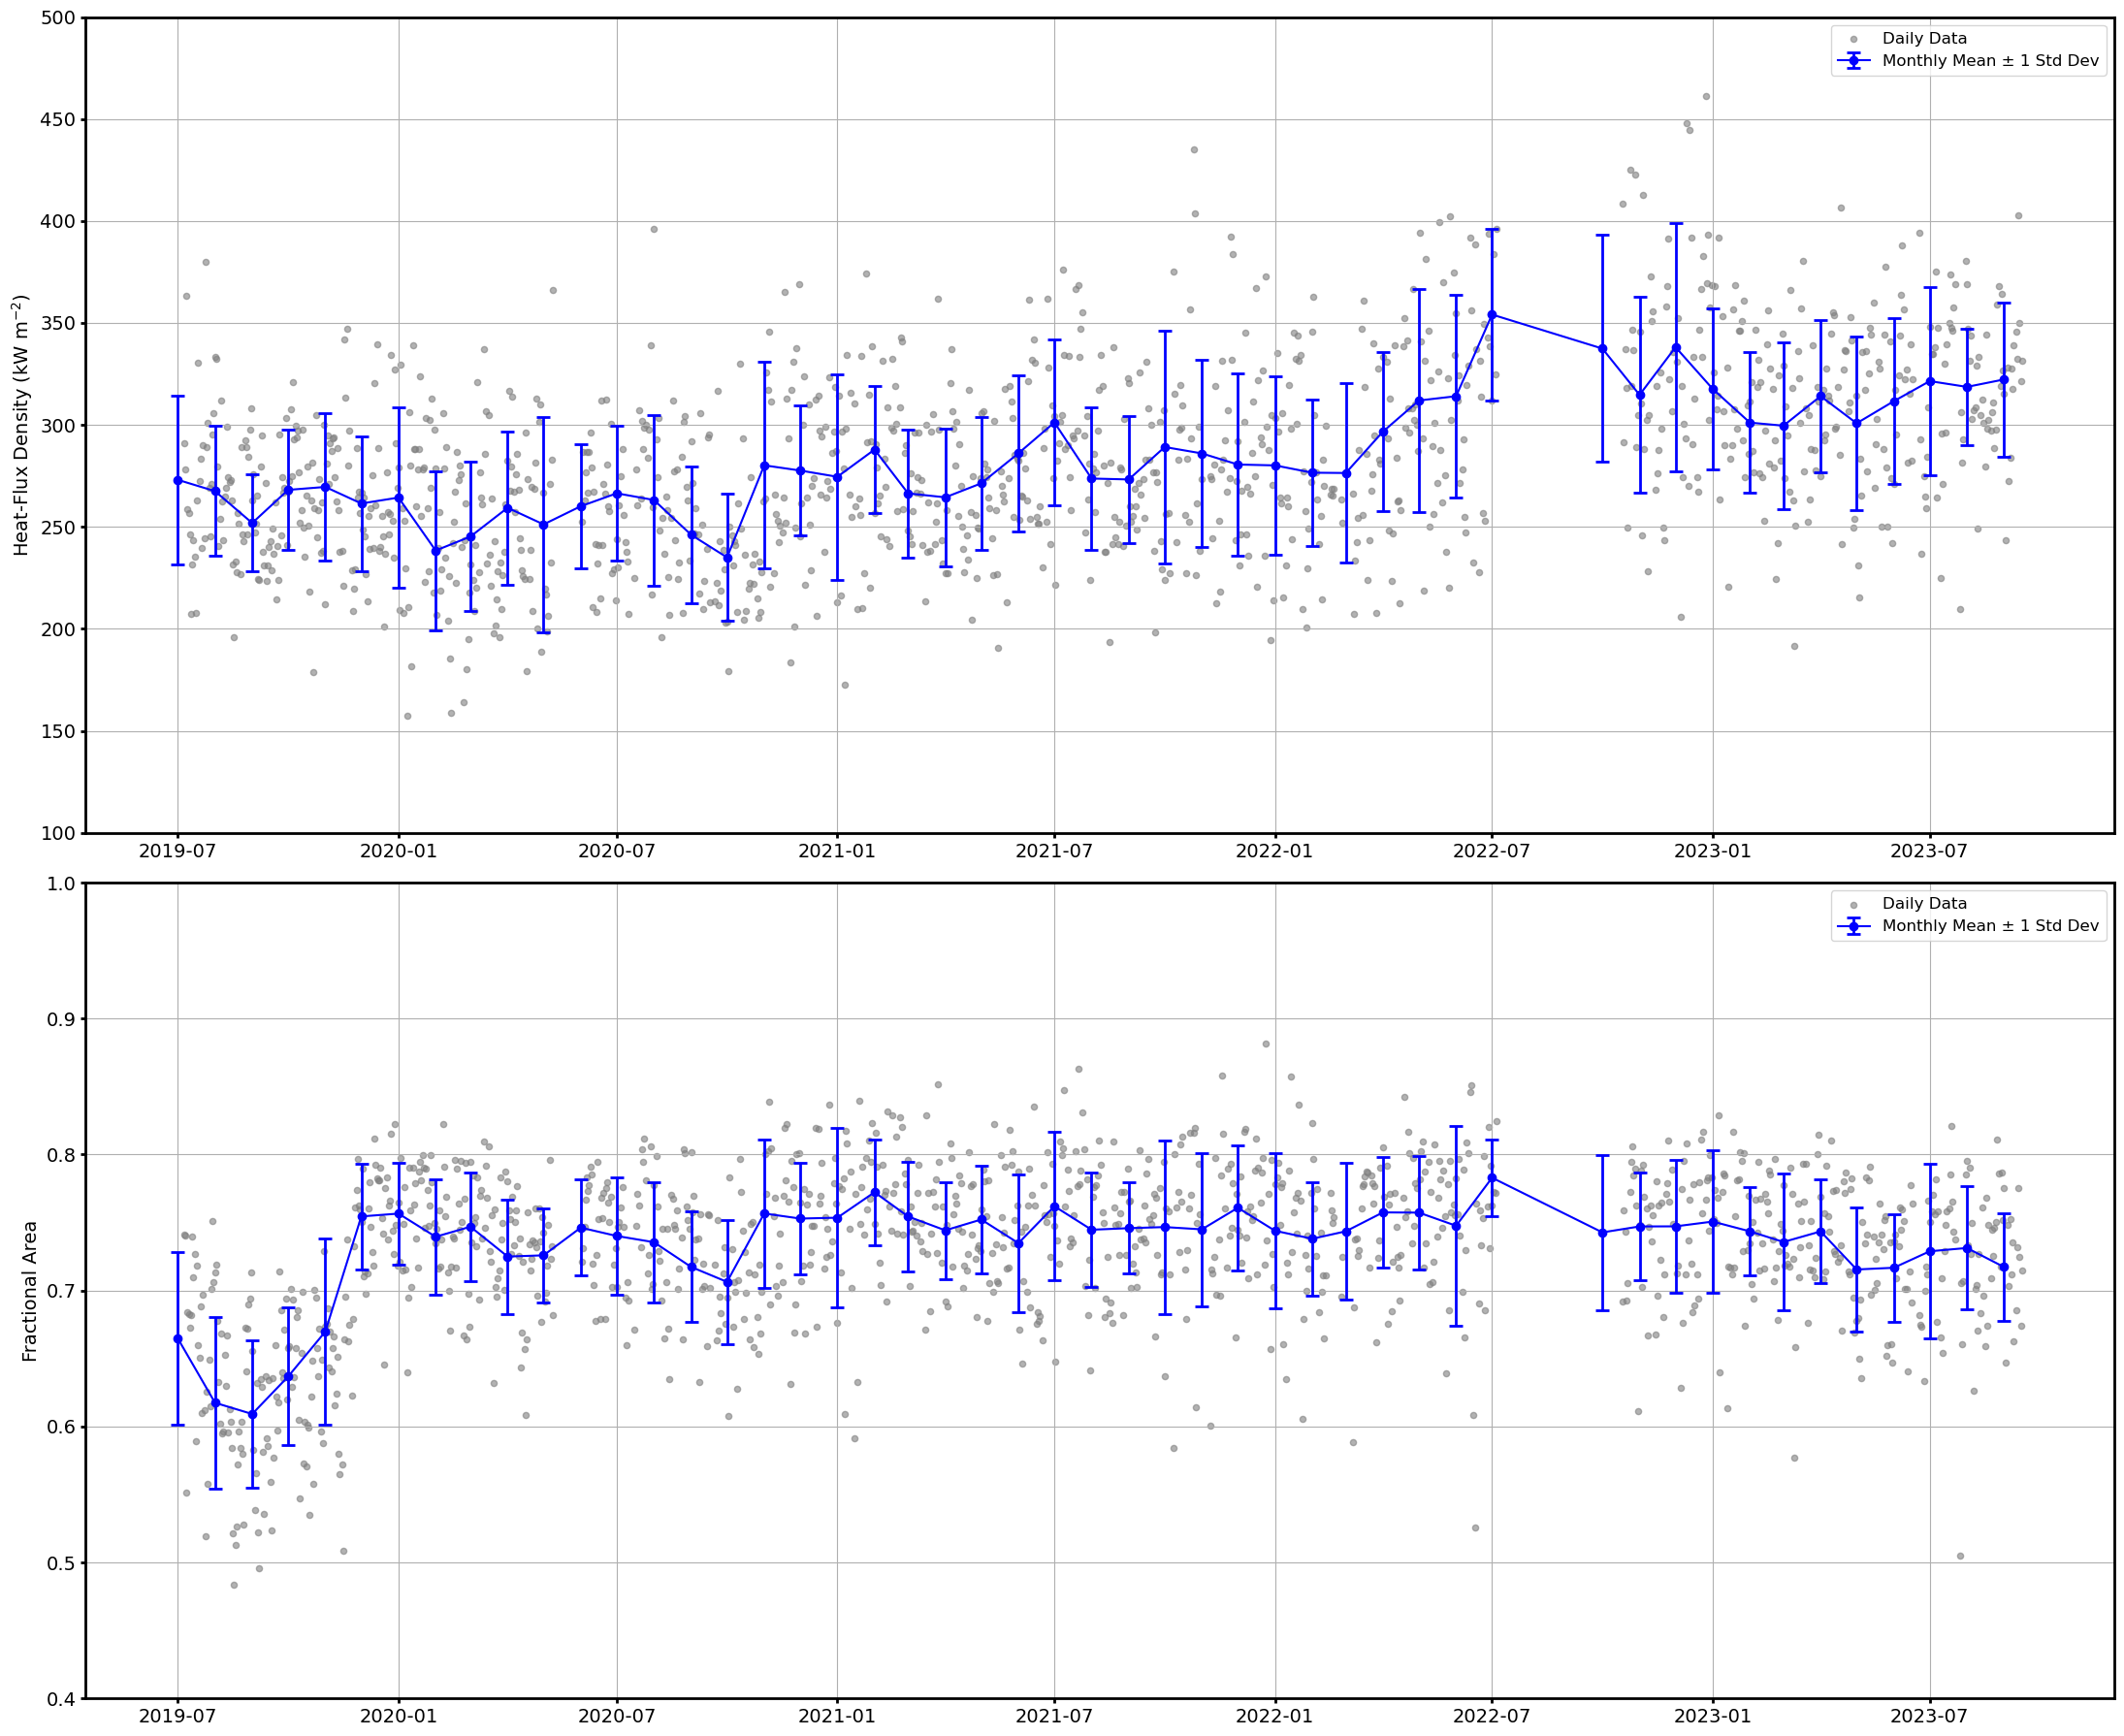

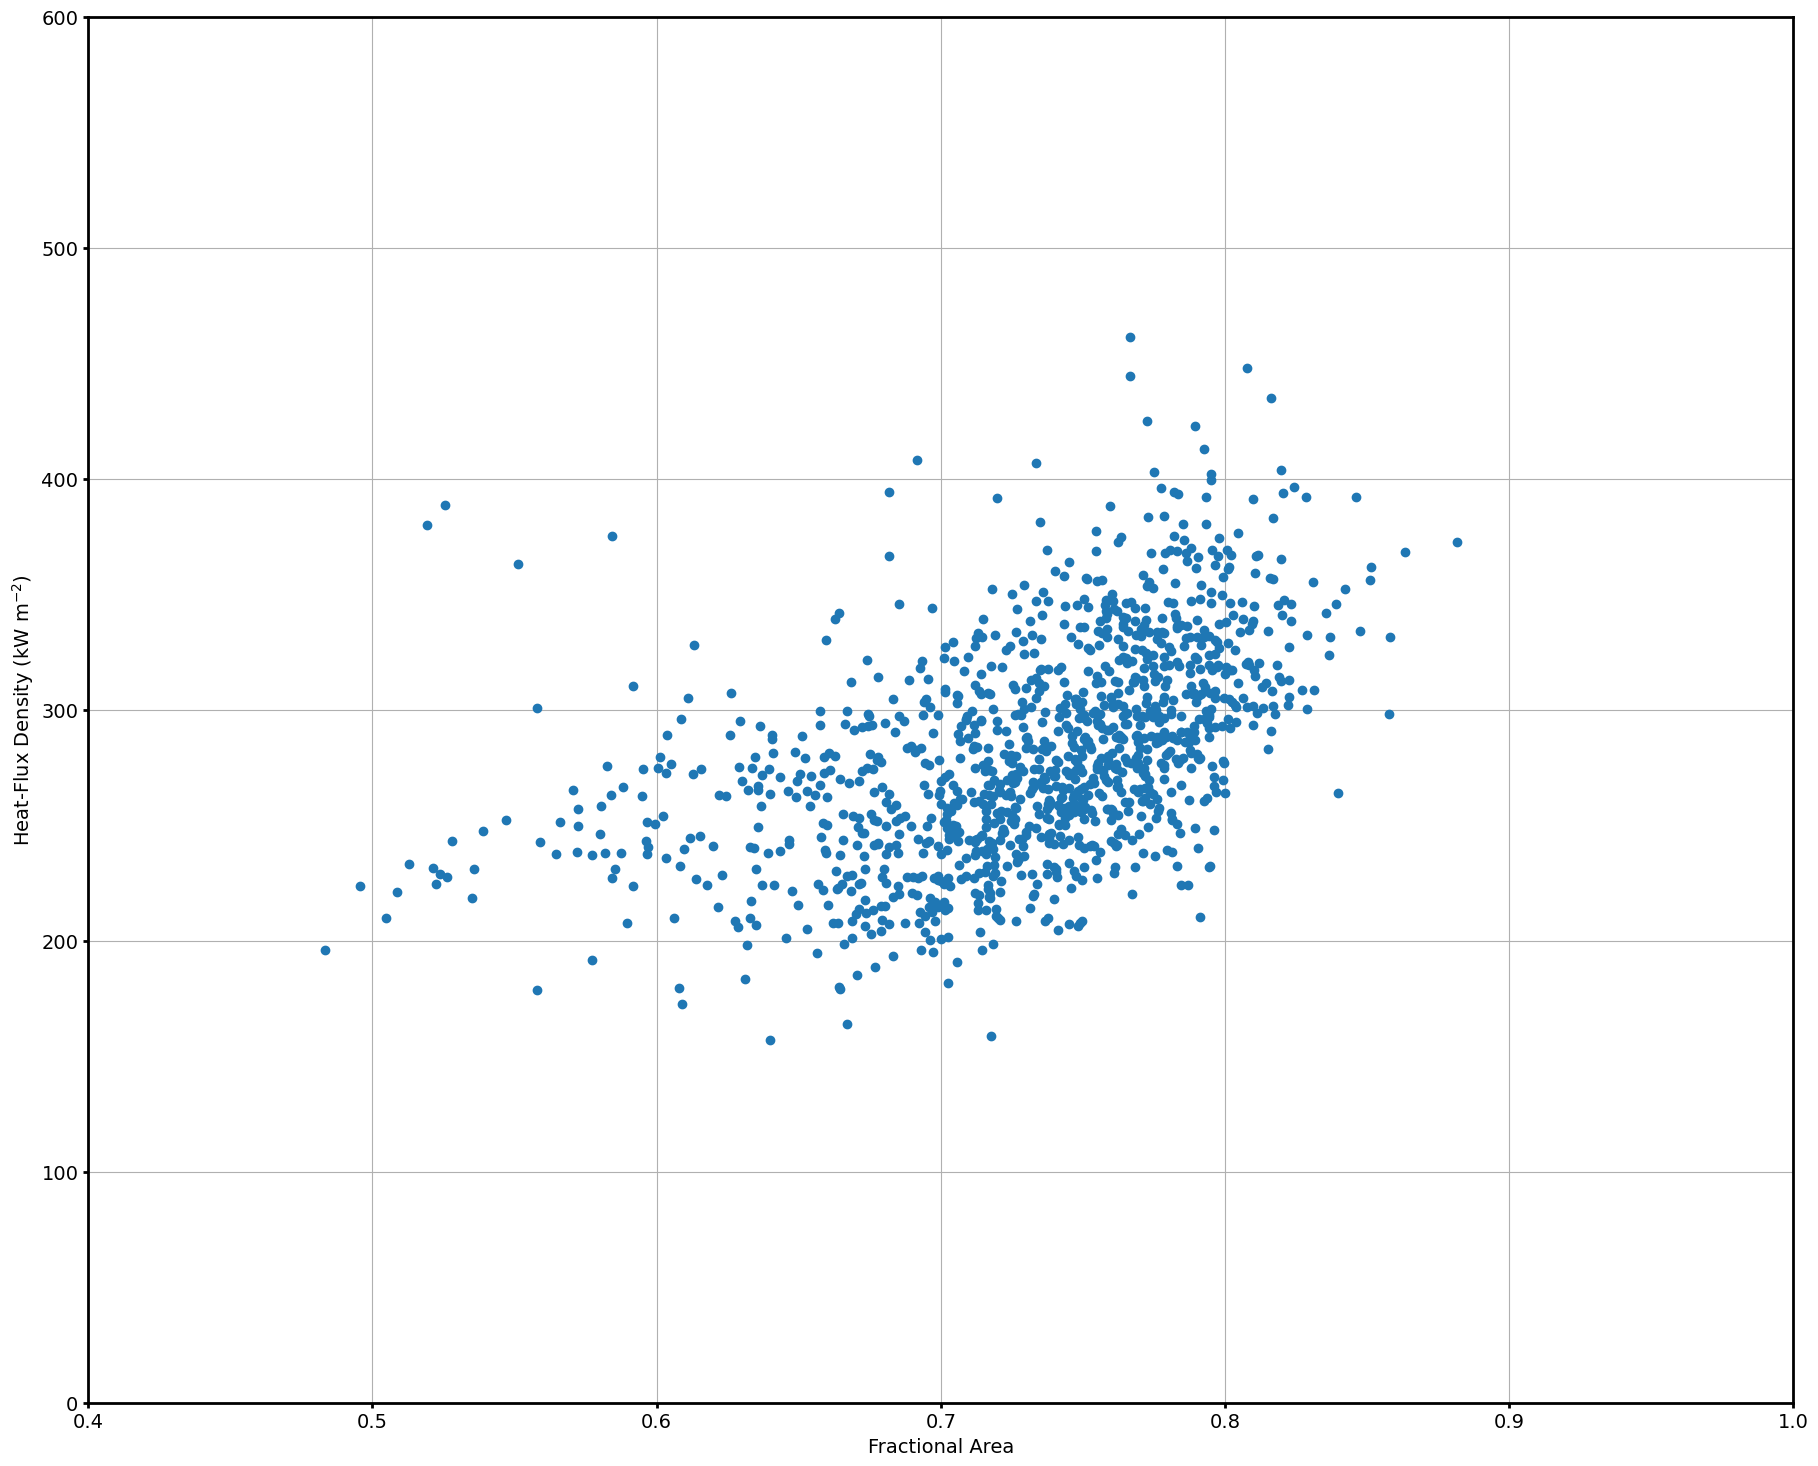

In [3]:
# -----------------------------------------------------------
# Prepare data for plots
# -----------------------------------------------------------

# Convert list to DataFrame for easy time grouping
df = pd.DataFrame({
    "Date": t_plot,  # Already in datetime format
    "Heat Flux Density (kW/m²)": np.array(q_av_list) / 1000,  # Convert from W/m² to kW/m²
    "Fractional Area": A_fract_list
})

# Group by month and compute mean & standard deviation
df["Year-Month"] = df["Date"].dt.to_period("M")  # Extract year-month for grouping
monthly_stats = df.groupby("Year-Month")["Heat Flux Density (kW/m²)"].agg(["mean", "std"]).reset_index()
monthly_frac_stats = df.groupby("Year-Month")["Fractional Area"].agg(["mean", "std"]).reset_index()

# Convert Period back to datetime for plotting
monthly_stats["Year-Month"] = monthly_stats["Year-Month"].dt.to_timestamp()
monthly_frac_stats["Year-Month"] = monthly_frac_stats["Year-Month"].dt.to_timestamp()

# -----------------------------------------------------------
# Plot the Results
# -----------------------------------------------------------

# Create figure with two subplots.
plt.figure(figsize=(22, 18))

# ----- Subplot 1: Average Heat Flux Density vs. Time (with Monthly Mean & Std Dev) -----
plt.subplot(2, 1, 1)
# Plot the original scatter points
plt.scatter(df["Date"], df["Heat Flux Density (kW/m²)"], color="gray", alpha=0.6, label="Daily Data", s=20)

# Plot the monthly mean with error bars
plt.errorbar(monthly_stats["Year-Month"], monthly_stats["mean"], yerr=monthly_stats["std"], 
             fmt='o-', capsize=5, capthick=2, elinewidth=2, color="blue", label="Monthly Mean ± 1 Std Dev")

plt.grid(True)
plt.ylabel('Heat-Flux Density (kW m$^{-2}$)', fontsize=14)
plt.ylim(100, 500)
plt.legend(fontsize=12)
# Enhance axis appearance
ax1 = plt.gca()
for spine in ax1.spines.values():
    spine.set_linewidth(2)
ax1.tick_params(width=2, labelsize=14)

# ----- Subplot 2: Fractional Active Area vs. Time (with Monthly Mean & Std Dev) -----
plt.subplot(2, 1, 2)
# Plot original scatter points
plt.scatter(df["Date"], df["Fractional Area"], color="gray", alpha=0.6, label="Daily Data", s=20)

# Plot the monthly mean with error bars
plt.errorbar(monthly_frac_stats["Year-Month"], monthly_frac_stats["mean"], yerr=monthly_frac_stats["std"], 
             fmt='o-', capsize=5, capthick=2, elinewidth=2, color="blue", label="Monthly Mean ± 1 Std Dev")

plt.grid(True)
plt.ylabel('Fractional Area', fontsize=14)
plt.ylim(0.4, 1)
plt.legend(fontsize=12)
# Enhance axis appearance
ax2 = plt.gca()
for spine in ax2.spines.values():
    spine.set_linewidth(2)
ax2.tick_params(width=2, labelsize=14)
plt.tight_layout()
plt.savefig("daily_data_stdev.png", bbox_inches='tight')

# Create the second figure: Average Heat Flux Density vs. Fractional Active Area.
plt.figure(figsize=(22, 18))
plt.plot(A_fract_list, np.array(q_av_list) / 1000, 'o', linewidth=1)
plt.xlim(0.4, 1)
plt.ylim(0, 600)
plt.ylabel('Heat-Flux Density (kW m$^{-2}$)', fontsize=14)
plt.xlabel('Fractional Area', fontsize=14)
plt.grid(True)
ax3 = plt.gca()
for spine in ax3.spines.values():
    spine.set_linewidth(2)
ax3.tick_params(width=2, labelsize=14)

plt.show()

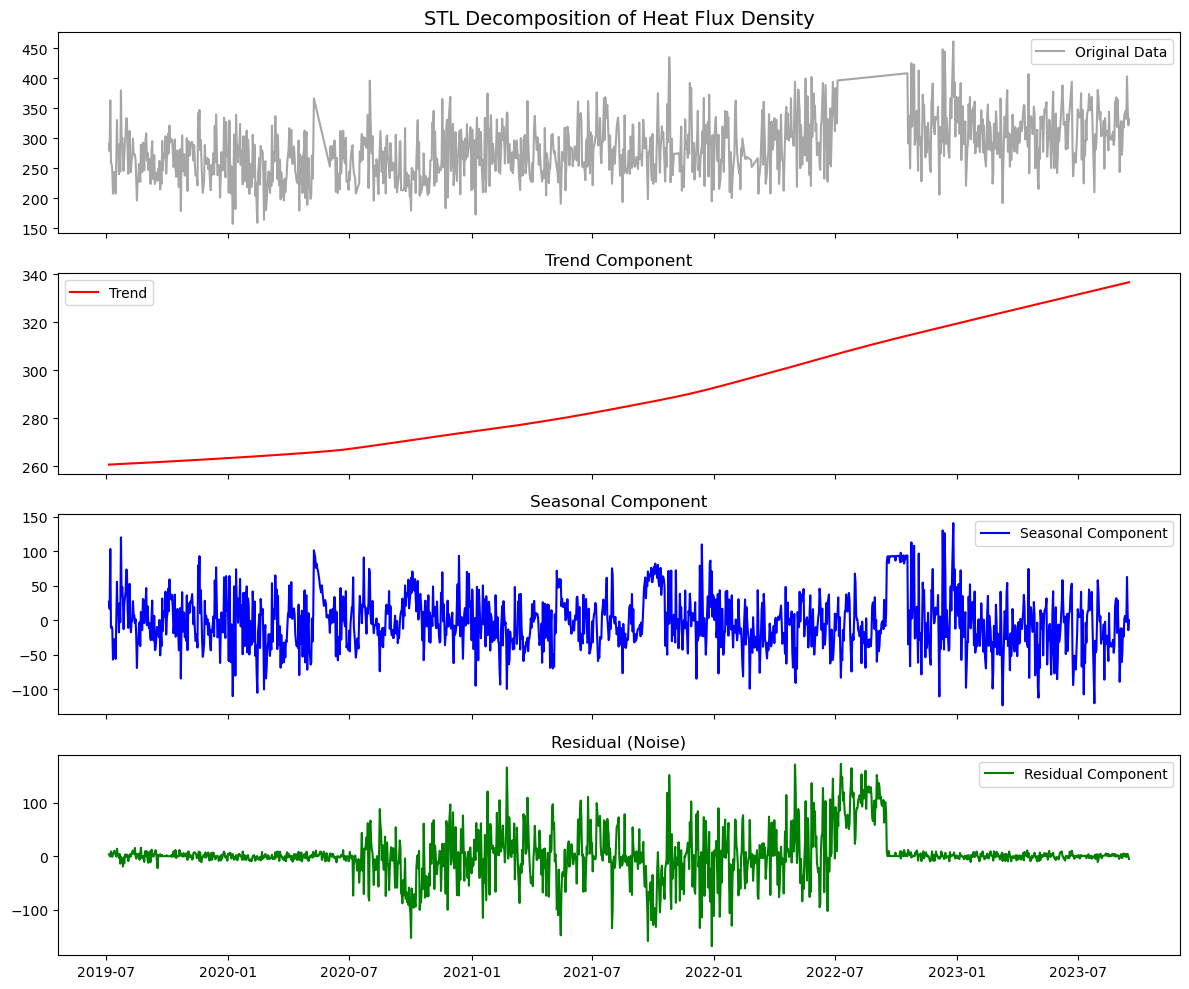

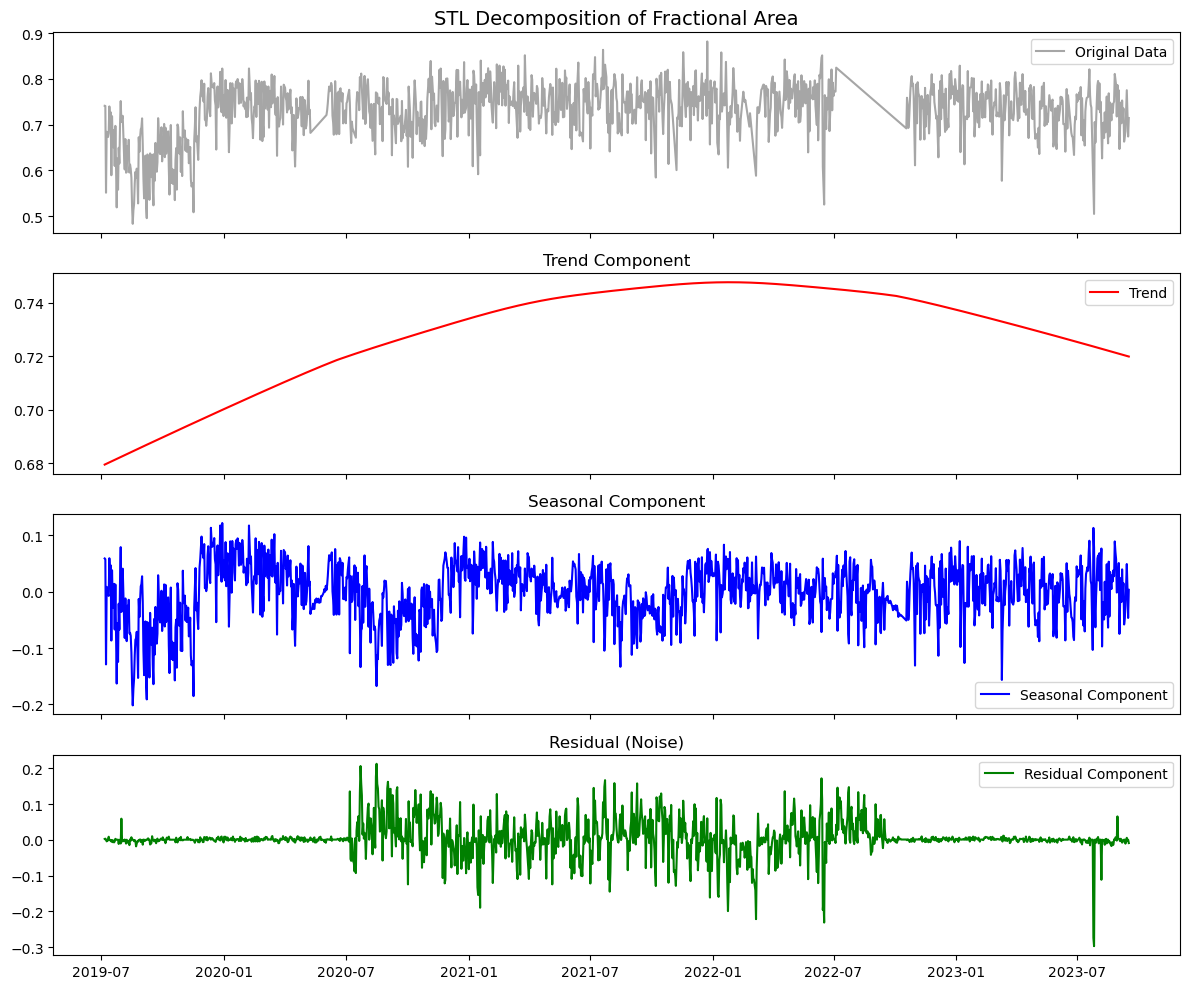

In [4]:
# Seasonal decomposition plots

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

# Convert data into a time series format
df = pd.DataFrame({
    "Date": t_plot,  # Dates
    "Heat Flux Density (kW/m²)": np.array(q_av_list) / 1000,  # Convert from W/m² to kW/m²
    "Fractional Area": A_fract_list
})

# Ensure the DataFrame is sorted by date
df = df.sort_values(by="Date")

# Set Date as Index and Resample to Daily Frequency (Fill Missing Days)
df.set_index("Date", inplace=True)
df = df.asfreq("D")  # Ensure a continuous daily time series

# Interpolate missing values (optional, but helps with decomposition)
df.interpolate(method="linear", inplace=True)

# Adjust the period for STL decomposition
# If data spans multiple years, use 365 (for annual seasonality), otherwise, try 30 (monthly).
period = 365 if len(df) > 365 else 30  # Adjust dynamically based on data length

# Apply STL decomposition
stl_heat_flux = STL(df["Heat Flux Density (kW/m²)"], period=period, robust=True).fit()
stl_frac_area = STL(df["Fractional Area"], period=period, robust=True).fit()

# -----------------------------------------------------------
# Plot STL Decomposition Results for Heat Flux Density
# -----------------------------------------------------------
fig, ax = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
ax[0].plot(df.index, df["Heat Flux Density (kW/m²)"], label="Original Data", color='gray', alpha=0.7)
ax[0].set_title("STL Decomposition of Heat Flux Density", fontsize=14)
ax[0].legend()

ax[1].plot(df.index, stl_heat_flux.trend, label="Trend", color='red')
ax[1].set_title("Trend Component")
ax[1].legend()

ax[2].plot(df.index, stl_heat_flux.seasonal, label="Seasonal Component", color='blue')
ax[2].set_title("Seasonal Component")
ax[2].legend()

ax[3].plot(df.index, stl_heat_flux.resid, label="Residual Component", color='green')
ax[3].set_title("Residual (Noise)")
ax[3].legend()

plt.tight_layout()
plt.show()

# -----------------------------------------------------------
# Plot STL Decomposition Results for Fractional Area
# -----------------------------------------------------------
fig, ax = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
ax[0].plot(df.index, df["Fractional Area"], label="Original Data", color='gray', alpha=0.7)
ax[0].set_title("STL Decomposition of Fractional Area", fontsize=14)
ax[0].legend()

ax[1].plot(df.index, stl_frac_area.trend, label="Trend", color='red')
ax[1].set_title("Trend Component")
ax[1].legend()

ax[2].plot(df.index, stl_frac_area.seasonal, label="Seasonal Component", color='blue')
ax[2].set_title("Seasonal Component")
ax[2].legend()

ax[3].plot(df.index, stl_frac_area.resid, label="Residual Component", color='green')
ax[3].set_title("Residual (Noise)")
ax[3].legend()

plt.tight_layout()
plt.show()


<Figure size 1200x500 with 0 Axes>

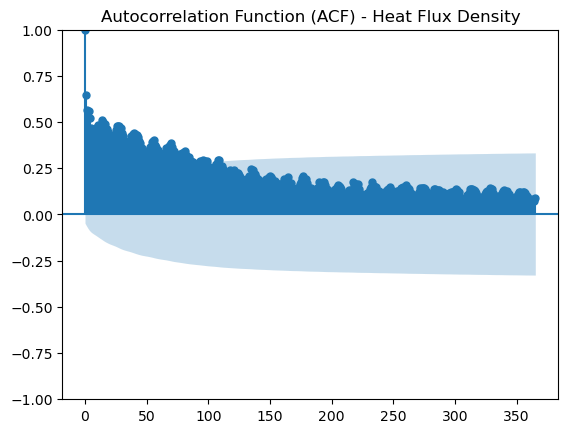

<Figure size 1200x500 with 0 Axes>

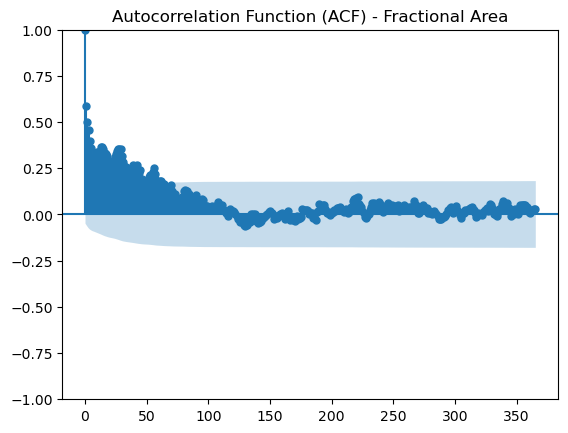

In [5]:
# Autocorrelation Function (ACF) Analysis
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Convert data into a time series format
df = pd.DataFrame({
    "Date": t_plot,  # Dates
    "Heat Flux Density (kW/m²)": np.array(q_av_list) / 1000,  # Convert from W/m² to kW/m²
    "Fractional Area": A_fract_list
})

# Ensure the DataFrame is sorted by date
df = df.sort_values(by="Date")

# Set Date as Index and Resample to Daily Frequency
df.set_index("Date", inplace=True)
df = df.asfreq("D")  # Ensure a continuous daily time series

# Interpolate missing values to handle gaps in the time series
df.interpolate(method="linear", inplace=True)

# -----------------------------------------------------------
# Plot ACF for Heat Flux Density
# -----------------------------------------------------------
plt.figure(figsize=(12, 5))
plot_acf(df["Heat Flux Density (kW/m²)"], lags=365, title="Autocorrelation Function (ACF) - Heat Flux Density")
plt.show()

# -----------------------------------------------------------
# Plot ACF for Fractional Area
# -----------------------------------------------------------
plt.figure(figsize=(12, 5))
plot_acf(df["Fractional Area"], lags=365, title="Autocorrelation Function (ACF) - Fractional Area")
plt.show()

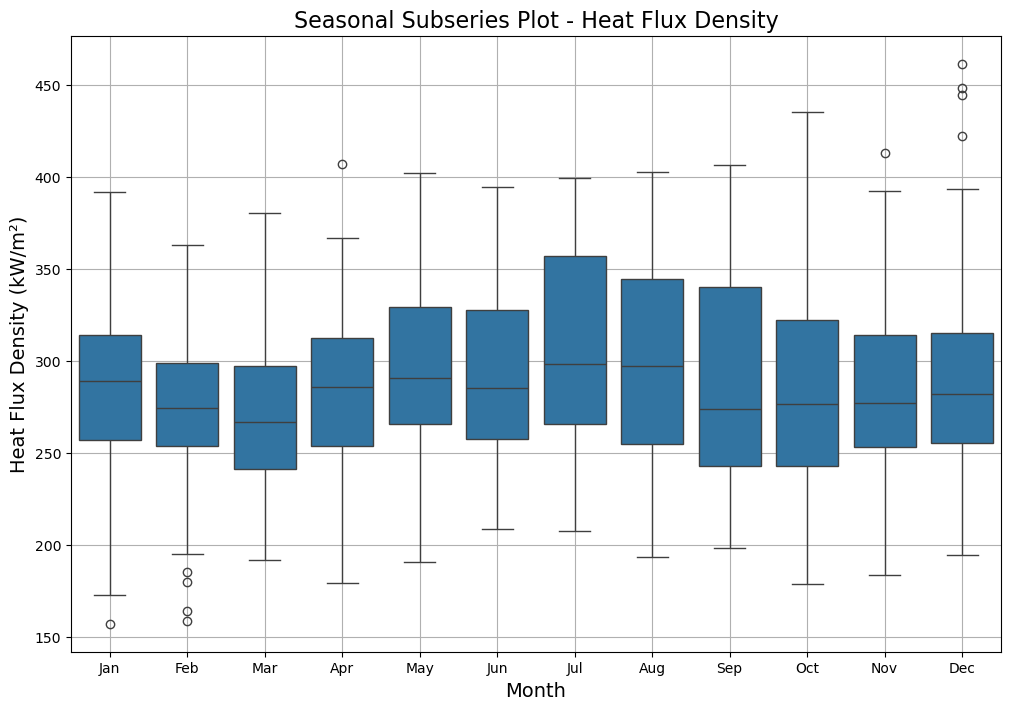

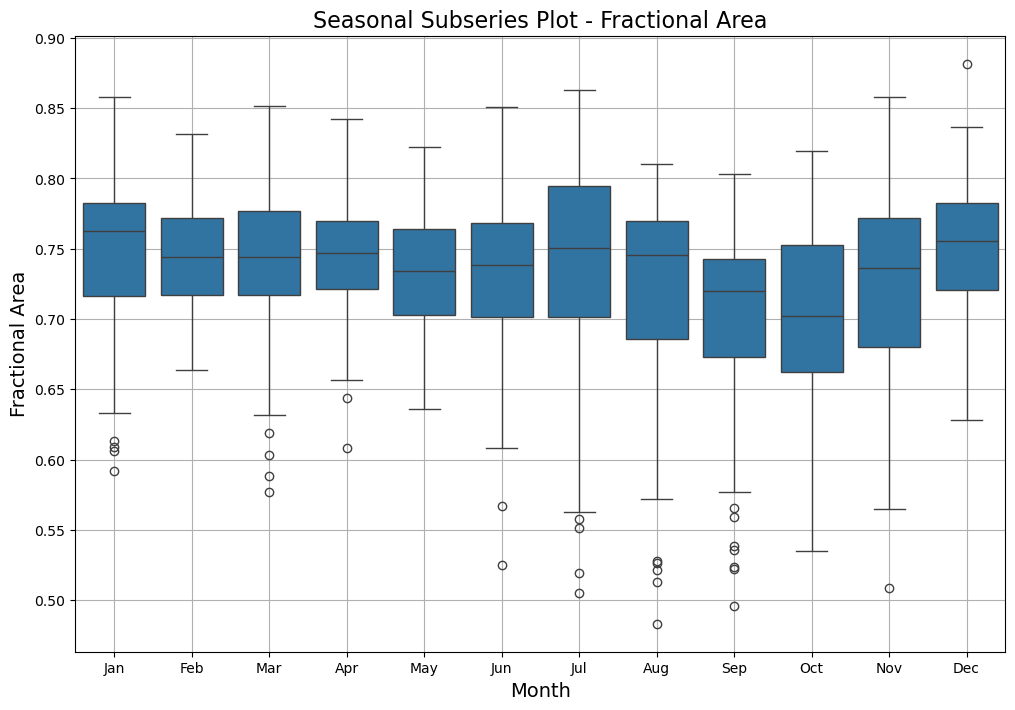

In [6]:
# Plot Seasonal Subseries Plot
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert data into a time series format
df = pd.DataFrame({
    "Date": t_plot,  # Dates
    "Heat Flux Density (kW/m²)": np.array(q_av_list) / 1000,  # Convert from W/m² to kW/m²
    "Fractional Area": A_fract_list
})

# Ensure the DataFrame is sorted by date
df = df.sort_values(by="Date")

# Set Date as Index and Resample to Daily Frequency
df.set_index("Date", inplace=True)
df = df.asfreq("D")  # Ensure a continuous daily time series

# Interpolate missing values to handle gaps in the time series
df.interpolate(method="linear", inplace=True)

# Create a new column for month labels (Jan, Feb, etc.)
df["Month"] = df.index.month
df["Month Name"] = df.index.strftime("%b")  # Get short month names

# -----------------------------------------------------------
# Plot Seasonal Subseries for Heat Flux Density
# -----------------------------------------------------------
plt.figure(figsize=(12, 8))
sns.boxplot(x="Month Name", y="Heat Flux Density (kW/m²)", data=df, 
            order=["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
                   "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.xlabel("Month", fontsize=14)
plt.ylabel("Heat Flux Density (kW/m²)", fontsize=14)
plt.title("Seasonal Subseries Plot - Heat Flux Density", fontsize=16)
plt.grid(True)
plt.show()

# -----------------------------------------------------------
# Plot Seasonal Subseries for Fractional Area
# -----------------------------------------------------------
plt.figure(figsize=(12, 8))
sns.boxplot(x="Month Name", y="Fractional Area", data=df, 
            order=["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
                   "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.xlabel("Month", fontsize=14)
plt.ylabel("Fractional Area", fontsize=14)
plt.title("Seasonal Subseries Plot - Fractional Area", fontsize=16)
plt.grid(True)
plt.show()


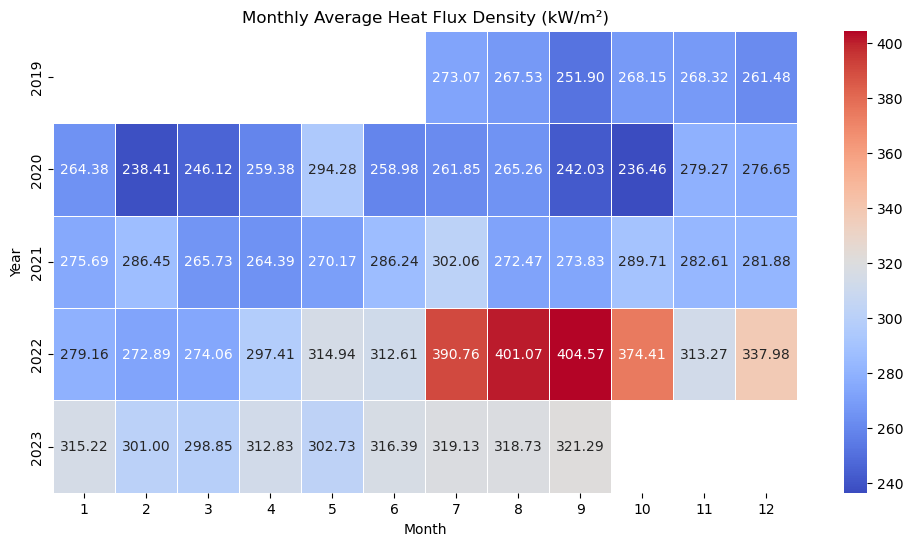

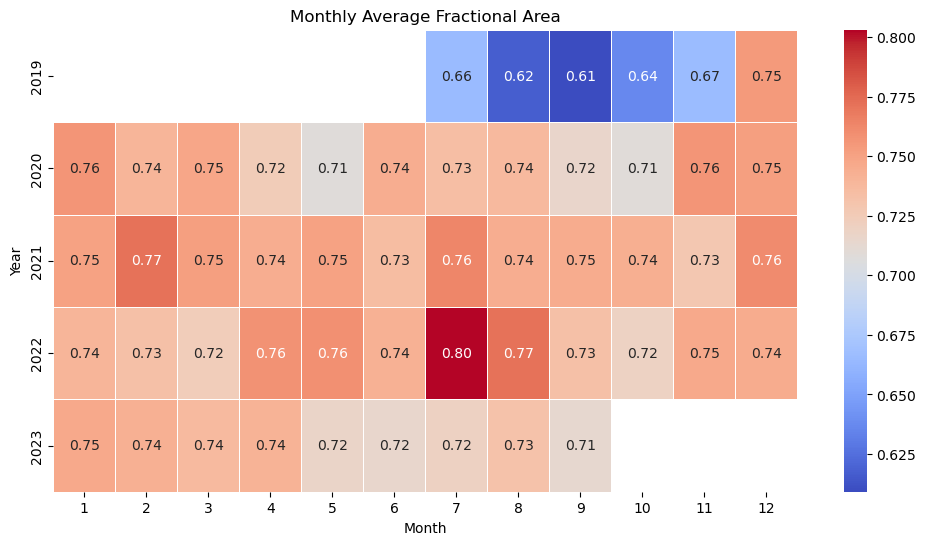

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract year and month for heatmap indexing
df["Year"] = df.index.year
df["Month"] = df.index.month

# Create pivot tables without filling missing values
heat_flux_pivot = df.pivot_table(index="Year", columns="Month", values="Heat Flux Density (kW/m²)", aggfunc="mean")
fractional_area_pivot = df.pivot_table(index="Year", columns="Month", values="Fractional Area", aggfunc="mean")

# Explicitly set missing values to NaN
heat_flux_pivot = heat_flux_pivot.where(pd.notna(heat_flux_pivot), np.nan)
fractional_area_pivot = fractional_area_pivot.where(pd.notna(fractional_area_pivot), np.nan)

# -----------------------------------------------------------
# Plot Heat Flux Density Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heat_flux_pivot, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5, mask=heat_flux_pivot.isnull())
plt.title("Monthly Average Heat Flux Density (kW/m²)")
plt.xlabel("Month")
plt.ylabel("Year")
plt.savefig("HeatMap_HFD.png", bbox_inches='tight')
plt.show()

# -----------------------------------------------------------
# Plot Fractional Area Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(fractional_area_pivot, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5, mask=fractional_area_pivot.isnull())
plt.title("Monthly Average Fractional Area")
plt.xlabel("Month")
plt.ylabel("Year")
plt.savefig("HeatMap_FA.png", bbox_inches='tight')
plt.show()


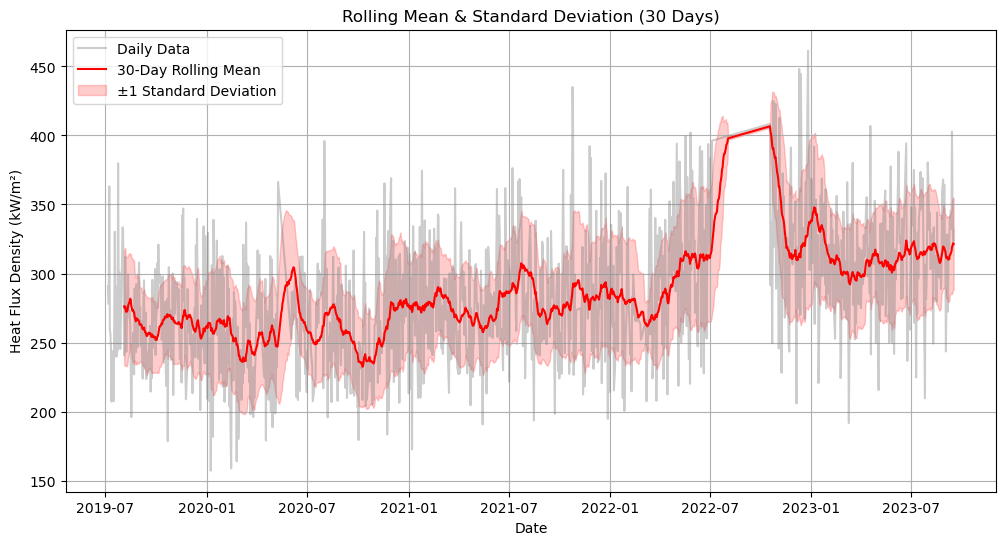

In [8]:
# Rolling mean and standard deviation plot
# Define rolling window (e.g., 30 days for monthly trends)
rolling_window = 30

# Compute rolling mean and std
df["Heat Flux Density Rolling Mean"] = df["Heat Flux Density (kW/m²)"].rolling(window=rolling_window).mean()
df["Heat Flux Density Rolling Std"] = df["Heat Flux Density (kW/m²)"].rolling(window=rolling_window).std()

# Plot rolling statistics
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Heat Flux Density (kW/m²)"], color="gray", alpha=0.4, label="Daily Data")
plt.plot(df.index, df["Heat Flux Density Rolling Mean"], color="red", label=f"{rolling_window}-Day Rolling Mean")
plt.fill_between(df.index, 
                 df["Heat Flux Density Rolling Mean"] - df["Heat Flux Density Rolling Std"], 
                 df["Heat Flux Density Rolling Mean"] + df["Heat Flux Density Rolling Std"], 
                 color='red', alpha=0.2, label="±1 Standard Deviation")
plt.xlabel("Date")
plt.ylabel("Heat Flux Density (kW/m²)")
plt.title(f"Rolling Mean & Standard Deviation ({rolling_window} Days)")
plt.legend()
plt.grid()
plt.show()


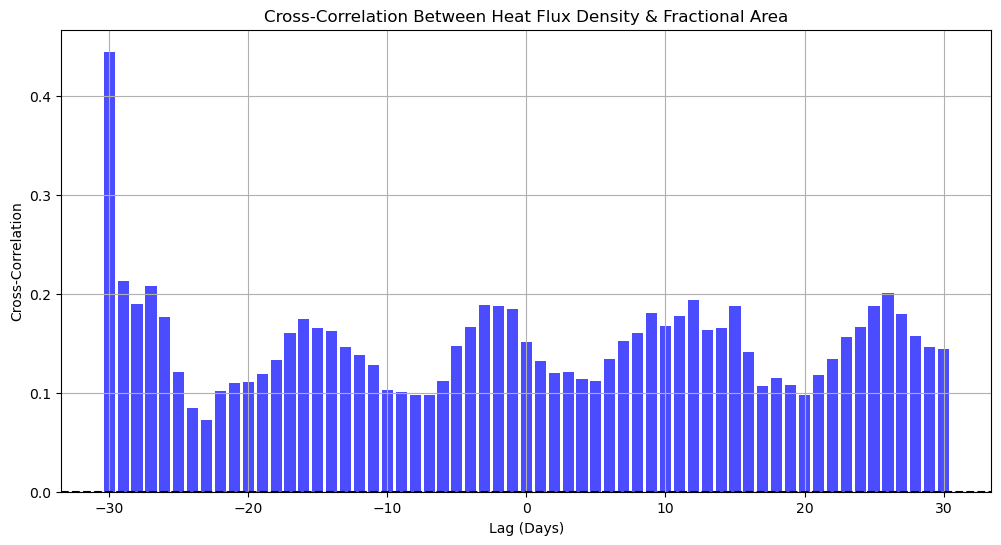

In [9]:
# Cross-Correlation Between Heat Flux Density & Fractional Area
import numpy as np
from statsmodels.tsa.stattools import ccf

# Compute cross-correlation
cross_corr = ccf(df["Heat Flux Density (kW/m²)"].dropna(), df["Fractional Area"].dropna(), adjusted=False)

# Define lags
lags = np.arange(-30, 31)  # Check correlations for ±30 days

# Plot cross-correlation
plt.figure(figsize=(12, 6))
plt.bar(lags, cross_corr[:len(lags)], color="blue", alpha=0.7)
plt.axhline(0, color="black", linestyle="--")
plt.xlabel("Lag (Days)")
plt.ylabel("Cross-Correlation")
plt.title("Cross-Correlation Between Heat Flux Density & Fractional Area")
plt.grid()
plt.savefig("CrossCorrelation.png", bbox_inches='tight')
plt.show()


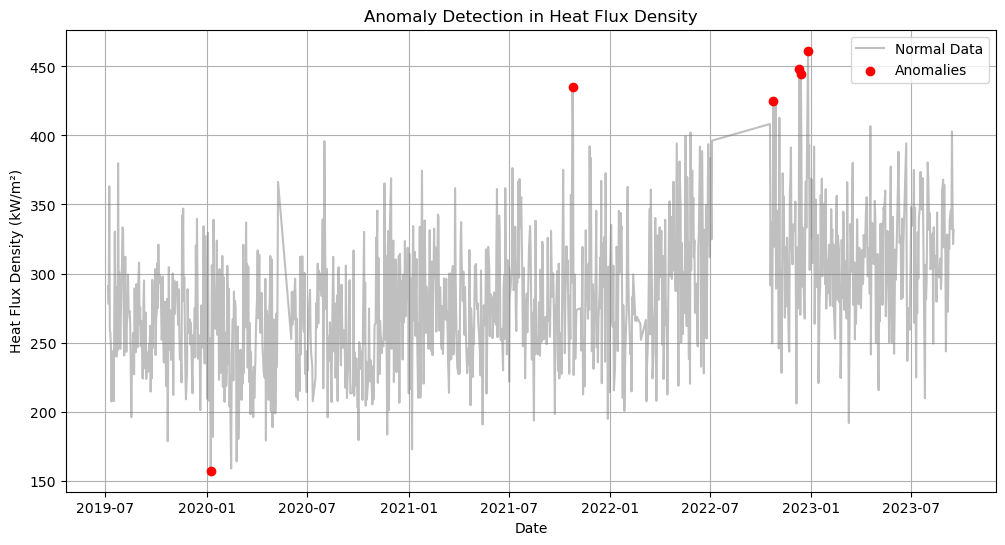

In [10]:
# Anamoly detection using z-scores
from scipy.stats import zscore

# Compute Z-Scores for anomaly detection
df["Heat Flux Z-Score"] = zscore(df["Heat Flux Density (kW/m²)"])

# Define anomaly threshold (e.g., beyond ±2.5 standard deviations)
anomaly_threshold = 2.5
anomalies = df[np.abs(df["Heat Flux Z-Score"]) > anomaly_threshold]

# Plot anomalies
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Heat Flux Density (kW/m²)"], color="gray", alpha=0.5, label="Normal Data")
plt.scatter(anomalies.index, anomalies["Heat Flux Density (kW/m²)"], color="red", label="Anomalies", zorder=3)
plt.xlabel("Date")
plt.ylabel("Heat Flux Density (kW/m²)")
plt.title("Anomaly Detection in Heat Flux Density")
plt.legend()
plt.grid()
plt.show()


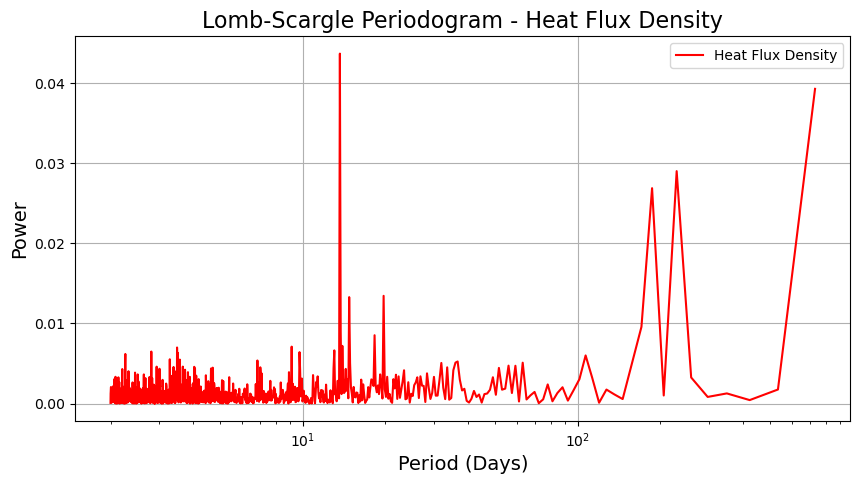

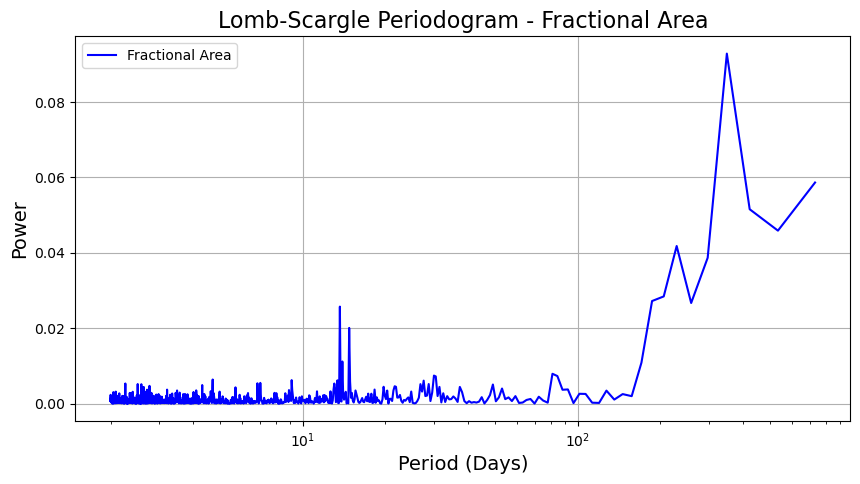

In [11]:
# Lomb-Scargle Analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle

# Convert data into a Pandas DataFrame
df = pd.DataFrame({
    "Date": t_plot,  # Dates
    "Heat Flux Density (kW/m²)": np.array(q_av_list) / 1000,  # Convert from W/m² to kW/m²
    "Fractional Area": A_fract_list
})

# Ensure the DataFrame is sorted by date
df = df.sort_values(by="Date")

# Set Date as Index
df.set_index("Date", inplace=True)

# Convert dates to numerical time format (days since start)
df["Time"] = (df.index - df.index.min()).days

# Drop NaN values
df.dropna(inplace=True)

# Define frequency range for Lomb-Scargle analysis
min_period = 2      # Minimum period to detect (in days)
max_period = 365*2  # Maximum period to detect (2 years)
frequencies = np.linspace(1/max_period, 1/min_period, 1000)  # Convert periods to frequencies

# -----------------------------------------------------------
# Apply Lomb-Scargle to Heat Flux Density
# -----------------------------------------------------------
power_heat_flux = LombScargle(df["Time"], df["Heat Flux Density (kW/m²)"]).power(frequencies)
periods = 1 / frequencies  # Convert frequencies back to periods

# Plot Lomb-Scargle Periodogram for Heat Flux Density
plt.figure(figsize=(10, 5))
plt.plot(periods, power_heat_flux, color='red', label="Heat Flux Density")
plt.xlabel("Period (Days)", fontsize=14)
plt.ylabel("Power", fontsize=14)
plt.title("Lomb-Scargle Periodogram - Heat Flux Density", fontsize=16)
plt.xscale("log")  # Use logarithmic scale for better visualization
plt.grid(True)
plt.legend()
plt.savefig("Lomb-Scargle_HFD.png", bbox_inches='tight')
plt.show()

# -----------------------------------------------------------
# Apply Lomb-Scargle to Fractional Area
# -----------------------------------------------------------
power_fractional_area = LombScargle(df["Time"], df["Fractional Area"]).power(frequencies)

# Plot Lomb-Scargle Periodogram for Fractional Area
plt.figure(figsize=(10, 5))
plt.plot(periods, power_fractional_area, color='blue', label="Fractional Area")
plt.xlabel("Period (Days)", fontsize=14)
plt.ylabel("Power", fontsize=14)
plt.title("Lomb-Scargle Periodogram - Fractional Area", fontsize=16)
plt.xscale("log")
plt.grid(True)
plt.legend()
plt.savefig("Lomb-Scargle_FA.png", bbox_inches='tight')
plt.show()


